In [610]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, roc_auc_score,precision_score, f1_score,recall_score

import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
%matplotlib inline

# 1. Data Preparation

In [611]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1.1. Transcript Data

In [612]:
transcript.event.value_counts(dropna=False)

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [614]:
transcript['offer_id'] = transcript.value.apply(lambda x: list(x.values())[0])
transcript['offer_id_amt_source'] = transcript.value.apply(lambda x: list(x.keys())[0])
transcript.drop(columns = 'value', inplace = True)
transcript.head()

,person,event,time,offer_id,offer_id_amt_source
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,offer id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,offer id
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id


In [616]:
# Removed offer event rows, only keep transaction rows.
txn = transcript[transcript.event == 'transaction'].drop(columns = 'offer_id_amt_source').rename(columns = {'offer_id': 'amt'})
txn.head(3)

,person,event,time,amt
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23


In [943]:
# check missing values
transcript.isnull().sum(axis = 0)

person                 0
event                  0
time                   0
offer_id               0
offer_id_amt_source    0
dtype: int64

## 1.2. Portfolio Data

In [793]:
portfolio_c = portfolio.copy()
portfolio_c['channels'] = portfolio_c['channels'].str.join(',')
channel_split = portfolio_c['channels'].str.get_dummies(',')
portfolio_c = portfolio_c.merge(channel_split, left_index=True, right_index=True)
portfolio_c.rename(columns = {"id": "offer_id"}, inplace = True)

portfolio_c.head()

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,"email,mobile,social",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"web,email,mobile,social",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"web,email,mobile",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"web,email,mobile",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"web,email",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [977]:
portfolio_c.offer_id.nunique()

10

In [978]:
# decode offer ids
portfolio_c['offer_id_short'] = portfolio_c.offer_id.map({
       '2906b810c7d4411798c6938adc9daaa5': '1',
       '3f207df678b143eea3cee63160fa8bed': '2',
       '5a8bc65990b245e5a138643cd4eb9837': '3',
       'f19421c1d4aa40978ebb69ca19b0e20d': '4',
       'fafdcd668e3743c1bb461111dcafc2a4': '5',
       '4d5c57ea9a6940dd891ad53e9dbe8da0': '6',
       'ae264e3637204a6fb9bb56bc8210ddfd': '7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2': '8',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9': '9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7': '10'})

In [979]:
# check missing values
portfolio_c.isnull().mean()

reward            0.0
channels          0.0
difficulty        0.0
duration          0.0
offer_type        0.0
offer_id          0.0
email             0.0
mobile            0.0
social            0.0
web               0.0
offer_id_short    0.0
dtype: float64

## 1.3. Profile Data

In [980]:
profile_c = profile.copy()
profile_c['start_dt'] = pd.to_datetime(profile_c['became_member_on'], format='%Y%m%d')
profile_c['tenure'] = (datetime(2020,1,1) - profile_c['start_dt']).dt.days
profile_c.drop(columns = ['became_member_on','start_dt'], inplace = True)
profile_c.rename(columns = {"id": "person"}, inplace= True)
profile_c.head()

,gender,age,person,income,tenure
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,1053
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,900
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,538
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,967
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,880


In [981]:
# check missing values
profile_c.isnull().mean()

gender    0.127941
age       0.000000
person    0.000000
income    0.127941
tenure    0.000000
dtype: float64

### 1.3.1. Remove Missing Value 

In [982]:
profile_clean = profile_c[profile_c.gender.isin(['F','M'])]
# check missing values
profile_clean.isnull().mean()

gender    0.0
age       0.0
person    0.0
income    0.0
tenure    0.0
dtype: float64

# 2. Exploratory Data Analysis
## 2.1. More Data Manipulations

### 2.1.1. Create Offer Level DataFrame

In [983]:
offer_txn = transcript[transcript.event != 'transaction'].merge(portfolio_c, on = 'offer_id', how = 'left') \
    .merge(profile_clean, on = 'person', how = 'inner')

In [984]:
offer_txn.shape

(146615, 19)

In [985]:
# offer level dataframe
conn = sqlite3.connect(':memory:')
offer_txn.to_sql('offer_txn', conn, index=False)

strsql='''
  select a.person, a.offer_id, a.time as time,  
       min(b.time) as view_time, 
       min(c.time) as complete_time,
       case when min(b.time) is not null and min(c.time) is not null then 1 else 0 end as success_offer,
       case when min(b.time) is not null then 1 else 0 end as viewed_offer
from (select * from offer_txn where event = 'offer received') a
left join (select * from offer_txn where event = 'offer viewed') b
  on a.person = b.person
  and a.offer_id = b.offer_id
  and b.time >= a.time and b.time <= a.time + a.duration * 24
left join (select * from offer_txn where event = 'offer completed') c
  on a.person = c.person
  and a.offer_id = c.offer_id
  and c.time >= b.time and c.time <= a.time + a.duration * 24
group by 1,2,3
'''

df_offer = pd.read_sql_query(strsql, conn)  

In [986]:
df_offer.success_offer.value_counts() # completed offer

0    43093
1    22492
Name: success_offer, dtype: int64

In [987]:
df_offer.viewed_offer.value_counts() # viewed offer

1    48354
0    17231
Name: viewed_offer, dtype: int64

### 2.1.2. Additional Feature

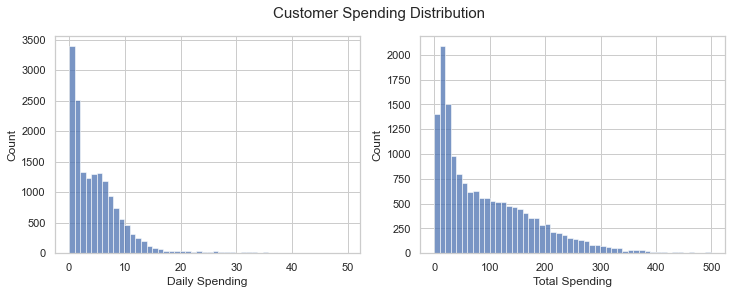

In [988]:
ttl_exp = txn.groupby('person').agg({'amt': 'sum', 'time':['min','max']}).droplevel(level = 0, axis = 1).rename(columns = {'sum': 'total_exp', 'min': 'track_st', 'max': 'track_end'}).reset_index()
ttl_exp['daily_exp'] = ttl_exp.total_exp/((ttl_exp.track_end - ttl_exp.track_st + 24)/24)


fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12, 4))
fig.suptitle('Customer Spending Distribution', fontsize = 15)

sns.histplot(ax = ax1, data=ttl_exp[ttl_exp.daily_exp < 50], x = 'daily_exp', bins = 50)
ax1.set_xlabel('Daily Spending')
sns.histplot(ax = ax2, data=ttl_exp[ttl_exp.total_exp < 500], x = 'total_exp', bins = 50)
ax2.set_xlabel('Total Spending')

plt.show();

## 2.2. Customer Age Validation

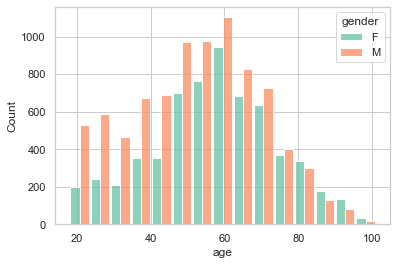

In [989]:
sns.histplot(data = profile_clean, x = "age", hue = "gender", multiple="dodge", shrink=.9, bins = 15, palette = 'Set2');

**Observation**
* Majority of Starbuck customers have age from 40 to 70, with yongest at 20 and oldest at 100.
* Within each age band, Starbucks is having more male customers then female, with minor exceptions in age band older than 80.

## 2.3. What's Affecting Offer View/Completion Rates?

### 2.3.1. Customer Features

In [990]:
# customer level dataset
# including customer features & offer viewed/completion

df_cust = df_offer.groupby('person').agg({'person': 'count', 'viewed_offer': 'sum', 'success_offer': 'sum'}).rename(columns = {'person': 'total_offer', 'viewed_offer': 'n_viewed', 'success_offer': 'n_completed'})
df_cust['view_rate'] = df_cust['n_viewed'] / df_cust['total_offer']
df_cust['completed_rate'] = df_cust['n_completed'] / df_cust['n_viewed']

df_cust2 = df_cust.merge(profile_clean, on = 'person', how = 'inner').merge(ttl_exp[['person','total_exp','daily_exp']], on = 'person', how = 'inner')

df_cust2['age_grp'] = pd.cut(df_cust2.age, bins = [17,40,55,66,102], labels = ["<40", "40-55", "56-66", ">66"])
df_cust2['income_grp'] = pd.cut(df_cust2.income, bins = [20000, 50000, 65000, 80000, 130000], labels = ["<50k", "50k-65k", "65k-80k", ">80k"])
df_cust2['tenure_grp'] = pd.cut(df_cust2.tenure, bins = [0, 730, 1095, 1460, 3000], labels = ["<2yr", "2yr-3yr", "3yr-4yr",">4yr"])
df_cust2['ttl_exp_grp'] = pd.cut(df_cust2.total_exp, bins = [0, 35, 90, 160, 3000], labels = ["<$35", "$35-$90", "$90-$160",">$160"])
df_cust2['daily_exp_grp'] = pd.cut(df_cust2.daily_exp, bins = [0, 2, 5, 8, 200], labels = ["<$2", "$2-$5", "$5-$8",">$8"])

In [991]:
# dataset for plots
melt_long = df_cust2.melt(id_vars = 'person', value_vars=['view_rate', 'completed_rate'], var_name = 'Rate_Type', value_name = 'Rate_Values')
df_cust3 = melt_long.merge(df_cust2[[col for col in df_cust2.columns if col not in ('view_rate','completed_rate')]], on = 'person', how = 'left')


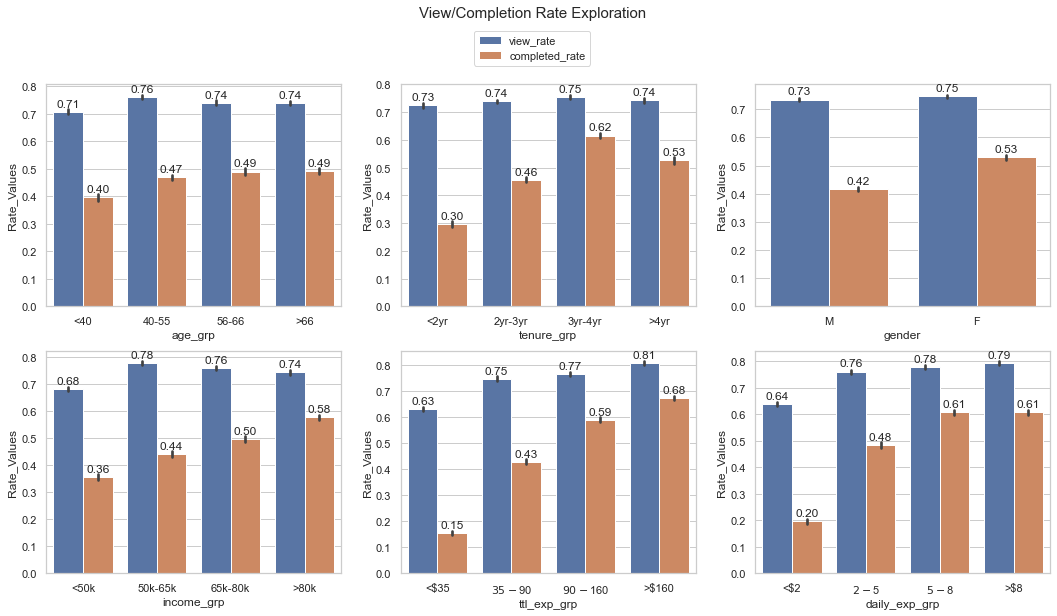

In [992]:
fig = plt.figure(figsize = (18, 9))

for i, col in enumerate(['age_grp','tenure_grp','gender','income_grp','ttl_exp_grp','daily_exp_grp']):
    plt.subplot(2,3,i+1)
    ax = sns.barplot(data = df_cust3, x = col, y = "Rate_Values", hue = "Rate_Type")
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding = 3)
    ax.legend_.remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc = "lower center", bbox_to_anchor = (0.5,0.9))
fig.suptitle('View/Completion Rate Exploration', fontsize = 15, y = 1)

plt.show();


**Observation**
* View rates are stable across different customers features/segments. That being said, chances of viewing the offers are comparable across customers.
* Completion rates see significant differences across **all** customer features.
* Total Dollar Spending and Daily Dollar Spending present similar trend again completion rates, with more dollar spending associated with higher offer completion rate. Later on we will pick Total Dollar Spending (`total_exp`) variable for modelling.

### 2.3.2. Offer Features Exploration

#### 2.3.2.1. View Rates

In [993]:
# Only channel will affect view rates. Other offer features are not seen yet.
df_offer_info = df_offer.merge(portfolio_c, how = 'left', on = "offer_id") 
channel_ttl = df_offer_info[['email','mobile','social','web']].sum(axis = 0)
channel_viewed = df_offer_info[df_offer_info.viewed_offer == 1][['email','mobile','social','web']].sum(axis = 0)

df_channel = pd.DataFrame({"ttl": channel_ttl, "viewed": channel_viewed}).reset_index().rename(columns={'index': 'channel'})
df_channel['view_ratio'] = df_channel['viewed']/df_channel['ttl']
df_channel

,channel,ttl,viewed,view_ratio
0,email,65585,48354,0.737272
1,mobile,58958,46133,0.782472
2,social,39270,36193,0.921645
3,web,52451,37211,0.709443


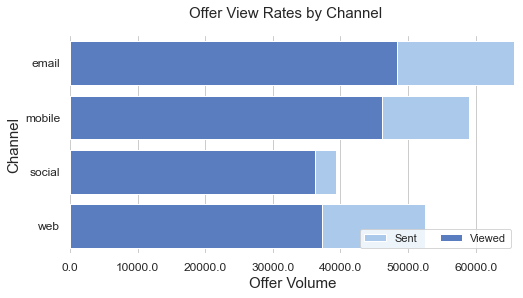

In [994]:
f, ax = plt.subplots(1, 1, figsize = (8, 4))
f.suptitle('Offer View Rates by Channel', fontsize = 15)

sns.set_color_codes("pastel")
sns.barplot(ax = ax, x = "ttl", y = "channel", data = df_channel, label = "Sent", color = "b")
sns.set_color_codes("muted")
sns.barplot(ax = ax, x = "viewed", y = "channel", data = df_channel, label = "Viewed", color = "b")
ax.legend(ncol = 2, loc = "lower right", frameon = True)
ax.set(xlim = (0, 66000))
ax.set_xlabel("Offer Volume", fontsize = 15)
ax.set_ylabel("Channel", fontsize = 15)
ax.set_xticklabels(ax.get_xticks(), size = 12)
ax.set_yticklabels(ax.get_yticklabels(), size = 12)
sns.despine(left = True, bottom = True)

**Observation**

Offers sent via social media are mostly viewed, with view rates ~90%. 

Other channels such as email, mobile, web see view rates around 70%.

#### 2.3.2.2. Completion Rates

In [995]:
df_offer_info.channels.value_counts(dropna=False)

web,email,mobile,social    26136
web,email,mobile           19688
email,mobile,social        13134
web,email                   6627
Name: channels, dtype: int64

In [996]:
df_offer_info['channel'] = df_offer_info.channels.map({'web,email,mobile,social': 'WEMS', 
                                                       'web,email,mobile': 'WEM',
                                                       'email,mobile,social': 'EMS',
                                                       'web,email': 'WE'})

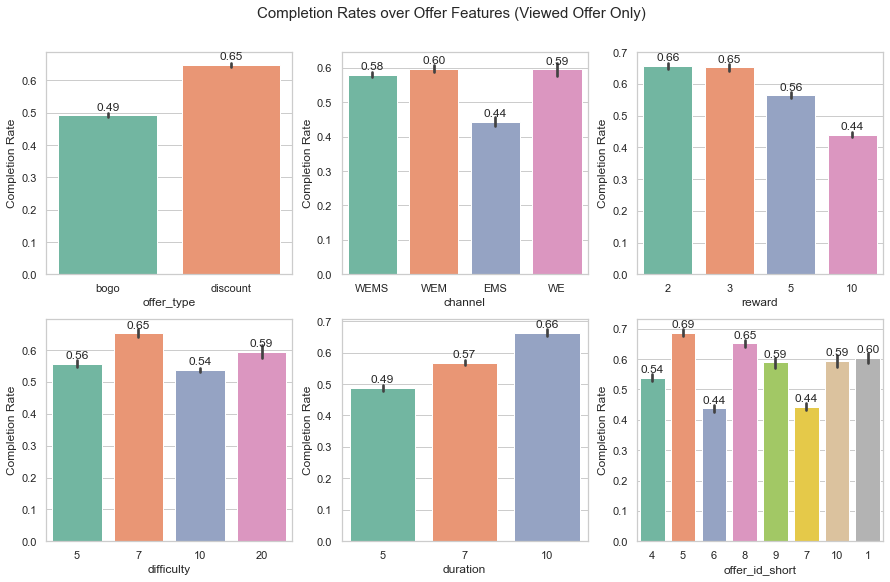

In [1054]:
# Compeltion Rates over offer features, 
# Only count on viewed offers.
# Exclude informational offers.
 
fig = plt.figure(figsize = (15, 9))
sns.set_color_codes("pastel")
for i, col in enumerate(['offer_type', 'channel', 'reward', 'difficulty', 'duration','offer_id_short']):
    plt.subplot(2,3,i+1)
    ax = sns.barplot(data = df_offer_info[(df_offer_info.viewed_offer == 1)&(df_offer_info.offer_type.isin(['bogo','discount']))], x = col, y = 'success_offer', palette=sns.color_palette("Set2"))
    ax.set_ylabel("Completion Rate")
    ax.bar_label(ax.containers[0], fmt="%.2f",padding = 3)

fig.suptitle('Completion Rates over Offer Features (Viewed Offer Only)', fontsize = 15, y=0.95)
plt.show();


In [1001]:
portfolio_c[['offer_id_short','offer_type', 'reward', 'difficulty','duration','channels']].sort_values(by = 'offer_id_short')

,offer_id_short,offer_type,reward,difficulty,duration,channels
9,1,discount,2,10,7,"web,email,mobile"
4,10,discount,5,20,10,"web,email"
2,2,informational,0,0,4,"web,email,mobile"
7,3,informational,0,0,3,"email,mobile,social"
8,4,bogo,5,5,5,"web,email,mobile,social"
6,5,discount,2,10,10,"web,email,mobile,social"
1,6,bogo,10,10,5,"web,email,mobile,social"
0,7,bogo,10,10,7,"email,mobile,social"
5,8,discount,3,7,7,"web,email,mobile,social"
3,9,bogo,5,5,7,"web,email,mobile"


**Observation**
* Most successful offers in terms of completion rates are: 
  > offer 5: 69% completion rate
  >
  > offer 8: 65% completion rate 

* Discount offers are more successful than BOGO offers.
* Offer 2 and Offer 3 are informational only, therefore no completion at all. Therefore in modelling part, we will remove observations from these 2 offer ids.
* In general, completion rate differences across offer features are heavily associated with offer itself. 

  For example, by plots offer with duration of 10 days are more likely to succeed, however this could also be explained by the fact that the most successful offer (offer 5) has 10 days duration.
 

## 3. Modelling
### 3.1. Get Design Matrix

In [897]:
df_view = df_offer.merge(portfolio_c, how = 'left', on = "offer_id").merge(profile_clean, on = 'person', how = 'inner').merge(ttl_exp[['person','total_exp','daily_exp']], on = 'person', how = 'inner')

var_select = ['success_offer', 'viewed_offer', 'reward', 'channels', 'difficulty','duration', 'offer_type','gender', 'age', 'income', 'tenure', 'total_exp']
df_model = df_view[df_view.offer_type.isin(['bogo','discount'])][var_select+['person']].set_index('person')

In [898]:
df_model.shape

(51309, 12)

In [900]:
feature = [var for var in var_select if var != 'success_offer']
print(feature)
X = df_model[feature]
Y = df_model['success_offer']

['viewed_offer', 'reward', 'channels', 'difficulty', 'duration', 'offer_type', 'gender', 'age', 'income', 'tenure', 'total_exp']


In [901]:
Y.value_counts() # balanced

0    28817
1    22492
Name: success_offer, dtype: int64

In [902]:
X.head(3)

,viewed_offer,reward,channels,difficulty,duration,offer_type,gender,age,income,tenure,total_exp
person,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0,2,"web,email,mobile",10,7,discount,M,33,72000.0,985,127.6
0009655768c64bdeb2e877511632db8f,1,5,"web,email,mobile,social",5,5,bogo,M,33,72000.0,985,127.6
0009655768c64bdeb2e877511632db8f,1,2,"web,email,mobile,social",10,10,discount,M,33,72000.0,985,127.6


### 3.2. Correlation Detection

In [903]:
# temporary dataset to factorize categorical variables for correlation plot
X_2 = pd.concat([X[[col for col in X.columns if col not in ('offer_type', 'gender', 'channels')]], X[['offer_type', 'gender','channels']].apply(lambda x: pd.factorize(x)[0])], axis = 1)

In [904]:
X_2.head()

,viewed_offer,reward,difficulty,duration,age,income,tenure,total_exp,offer_type,gender,channels
person,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0,2,10,7,33,72000.0,985,127.60,0,0,0
0009655768c64bdeb2e877511632db8f,1,5,5,5,33,72000.0,985,127.60,1,0,1
0009655768c64bdeb2e877511632db8f,1,2,10,10,33,72000.0,985,127.60,0,0,1
0020c2b971eb4e9188eac86d93036a77,1,10,10,5,59,90000.0,1398,196.86,1,1,1
0020c2b971eb4e9188eac86d93036a77,0,10,10,7,59,90000.0,1398,196.86,1,1,2


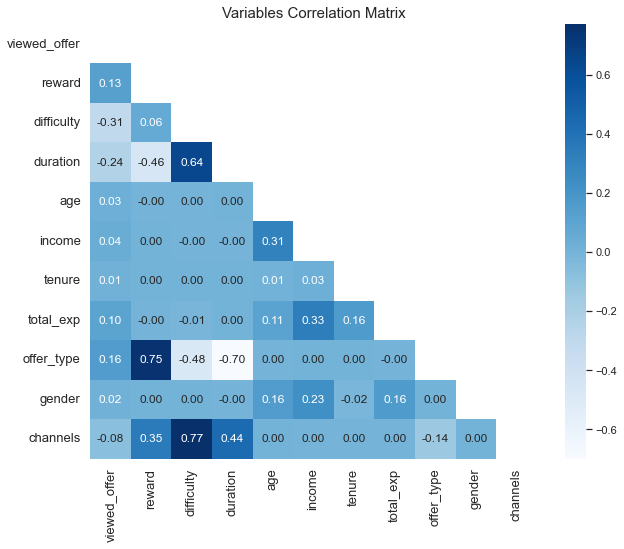

In [1006]:
corrs = X_2.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(corrs, annot = True, mask = mask, fmt = '.2f',cmap='Blues')
    ax.tick_params(labelsize=13)
    ax.set_title('Variables Correlation Matrix', size = 15);

**Observation**

Similar to what's been obseved from 2.3.2.2, offer features are highly correlated with each other, as they are mainly determined by offer_id itself.

1. Variable `offer_type` is highly correlated with `duration`, `reward` and `difficulty`.
2. Variable `duration` is highly correlated with `reward` and `difficulty`.
3. Variable `channels` is highly correlated with `duration`, `reward` and `difficulty`.

To eliminate correlation issues for Logistic regression, remove `offer_type`, `channels`, `duration`.

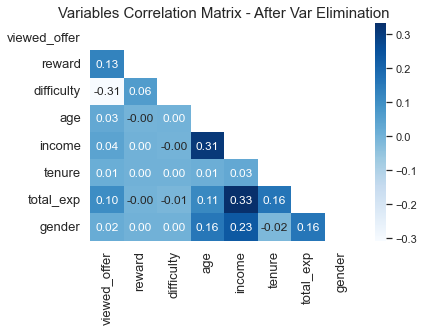

In [1005]:
# Correlation Matrix after variable elimination
corrs_tmp = X_2[[col for col in X_2.columns if col not in ('offer_type', 'channels', 'duration')]].corr()
mask = np.zeros_like(corrs_tmp)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots()
    ax = sns.heatmap(corrs_tmp, annot = True, mask = mask,fmt = '.2f',cmap='Blues')
    ax.tick_params(labelsize=13)
    ax.set_title('Variables Correlation Matrix - After Var Elimination', size = 15);


### 3.3. Train Test Split

In [907]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y, random_state = 20)


In [1007]:
print(X_train.columns)

Index(['viewed_offer', 'reward', 'channels', 'difficulty', 'duration',
       'offer_type', 'gender', 'age', 'income', 'tenure', 'total_exp'],
      dtype='object')


### 3.4. Build Model Pipelines
#### 3.4.1. Build Pre-processor (Imputing, Encoding, Scaling)

In [1024]:
# Pipeline Settings for ML algorithms

numeric_features = ['viewed_offer', 'reward', 'difficulty','duration','age','income','tenure', 'total_exp']
categorical_features = ['channels','offer_type','gender']

numeric_transformer = Pipeline(steps = [
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps = [
       ('imputer', SimpleImputer(strategy='constant'))
       ,('encoder', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(transformers = [
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
]) 

#  Settings for Logistic. Drop correlated variables, change OneHotEncoder.

numeric_features_2 = ['viewed_offer', 'reward', 'difficulty','age','income','tenure', 'total_exp']
categorical_features_2 = ['gender']


categorical_transformer2 = Pipeline(steps = [
       ('imputer', SimpleImputer(strategy='constant'))
       ,('encoder', OneHotEncoder(drop='first'))
])

preprocessor2 = ColumnTransformer(transformers = [
    ('numeric', numeric_transformer, numeric_features_2)
   ,('categorical', categorical_transformer2, categorical_features_2)
]) 


# Functions for model performance matrices
def Get_Performance(y_test, y_pred):
    """
    Calculate Classification Model Performance Matrices
    
    Input:
    y_test: A pd series of test response variable
    y_pred: A pd series of response variable predicted by the model

    Output:
    A pd DataFrame containing model testing AUC, F1 score, Precision, Recall and Accuracy. 
    """
    roc_value = roc_auc_score(y_test, y_pred)
    f1_scorevalue = f1_score(y_test, y_pred, labels = None, pos_label=1, average='weighted')
    rec = recall_score(y_test, y_pred,pos_label=1)
    prec = precision_score(y_test, y_pred, pos_label=1)
    acc = accuracy_score(y_test, y_pred)
    
    return pd.DataFrame({'Testing AUC': [roc_value], 'F1 Score': [f1_scorevalue], 'Precision': [prec], 'Recall': [rec], 'Accuracy': [acc]})
    #print(f''' Performance\n Testing AUC: {roc_value}\n F1 Score: {f1_scorevalue}\n Precision: {prec}\n Recall: {rec}\n Accuracy: {acc}''')

#### 3.4.2. Build Classifier

##### 3.4.2.1. Logistic Regression Model

In [913]:
X_train_2 = X_train[[col for col in X_train.columns if col not in ('offer_type', 'channels', 'duration')]]
X_test_2 = X_test[[col for col in X_test.columns if col not in ('offer_type', 'channels', 'duration')]]

In [ ]:
pipeline_logit = Pipeline(steps = [
               ('preprocessor', preprocessor2)
              ,('clf', LogisticRegression(random_state = 10))
           ])
pipeline_logit.fit(X_train_2, y_train)

In [1025]:
perm_logit = Get_Performance(y_test, pipeline_logit.predict(X_test_2))
print(perm_logit)

   Testing AUC  F1 Score  Precision    Recall  Accuracy
0     0.787963  0.787466     0.7375  0.797439  0.786795


In [1018]:
pipeline_logit.steps[1][1].coef_

array([[ 4.68544353, -0.39604147,  0.01353876,  0.04236219,  0.08752394,
         0.27338167,  0.97814781, -0.24633679]])

##### 3.4.2.2. Random Forest Classifier

In [910]:
# Parameters Tunning
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('clf', RandomForestClassifier())
           ])

parameters = {
    'clf__n_estimators': [100,200,300]
    , 'clf__max_features': ["sqrt", "log2"]
}

CV = GridSearchCV(pipeline, param_grid = parameters)
CV.fit(X_train, y_train)
CV.best_params_

{'clf__max_features': 'sqrt', 'clf__n_estimators': 300}

In [ ]:
pipeline_rf = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('clf', RandomForestClassifier(n_estimators = 300, max_features = 'sqrt', random_state = 10))
           ])
pipeline_rf.fit(X_train, y_train)

In [1026]:
perm_rf = Get_Performance(y_test, pipeline_rf.predict(X_test))
print(perm_rf)

   Testing AUC  F1 Score  Precision    Recall  Accuracy
0     0.792214  0.790062   0.733376  0.815935  0.789289


##### 3.4.2.3. Gradient Boosting Classifier

In [922]:
# Parameters Tunning
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('clf', GradientBoostingClassifier())
           ])
# pipeline.get_params()
parameters = {
     'clf__max_depth': [1,2,3,4]
    , 'clf__n_estimators': [100,200,300]
}

CV = GridSearchCV(pipeline, param_grid = parameters)
CV.fit(X_train, y_train)
CV.best_params_

{'clf__max_depth': 4, 'clf__n_estimators': 100}

In [ ]:
pipeline_gb = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('clf', GradientBoostingClassifier(n_estimators = 100, max_depth = 4, random_state = 10))
           ])
pipeline_gb.fit(X_train, y_train)

In [1027]:
perm_gb = Get_Performance(y_test, pipeline_gb.predict(X_test))
print(perm_gb)

   Testing AUC  F1 Score  Precision    Recall  Accuracy
0     0.819986  0.812734   0.738885  0.883692   0.81213


# 4. Model Evaluation & Conclustion
## 4.1. Model Metrices 

In [1029]:
all_perm = pd.concat([perm_logit, perm_rf, perm_gb])
all_perm['Model'] = ['Logistic', 'Random Forest', 'Gradient Boosting']
all_perm.set_index('Model', inplace=True)
all_perm

,Testing AUC,F1 Score,Precision,Recall,Accuracy
Model,,,,,
Logistic,0.787963,0.787466,0.737500,0.797439,0.786795
Random Forest,0.792214,0.790062,0.733376,0.815935,0.789289
Gradient Boosting,0.819986,0.812734,0.738885,0.883692,0.812130


For this study, `Accuracy` and `Recall` are preferred metrics for model performance. 

The consideration of picking `Recall` over `Precision` is that in production sense we would like to capture as many true positiives as possible to **increase coffee offer engagement**. On the other hand, getting many false positives (low precision) is less of a concern, since sending offer is almost free & it would not hurt business.

Based on `Accuracy` and `Recall` , it is clear that both Ramdom Forest Model and Gradient Boosting Model are performing well. We can rely on these 2 models to dig feature insights.

## 4.2. Feature Insights

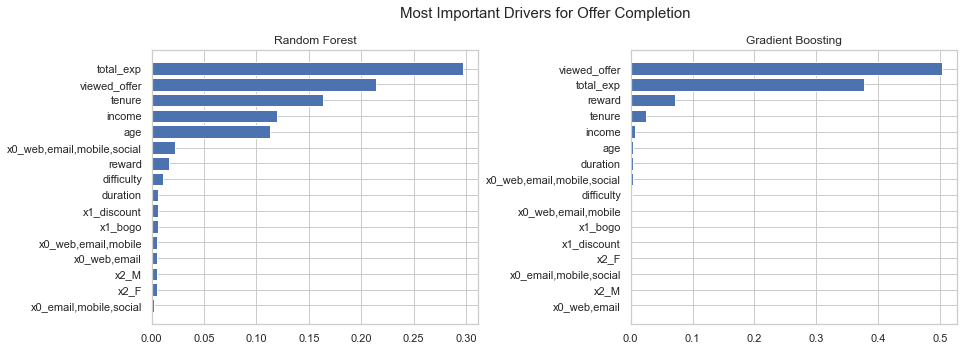

In [1047]:
var_rf = numeric_features + pipeline_rf.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names().tolist()
var_gb = numeric_features + pipeline_gb.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names().tolist()


fi_rf = pd.DataFrame({'feature': var_rf, 'importance': pipeline_rf.steps[1][1].feature_importances_}).sort_values('importance', ascending = True)
fi_gb = pd.DataFrame({'feature': var_gb, 'importance': pipeline_gb.steps[1][1].feature_importances_}).sort_values('importance', ascending = True)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12, 4.5))
fig.tight_layout(w_pad = 10)
fig.suptitle('Most Important Drivers for Offer Completion', fontsize = 15, y = 1.08)

ax1.barh(fi_rf.feature, fi_rf.importance)
ax1.set_title("Random Forest")
ax2.barh(fi_gb.feature, fi_gb.importance)
ax2.set_title("Gradient Boosting")

plt.show();

**Observation**
* Important features are consistent between the two models, as well as between modelling result and EDA analysis.
* Features driving the offer completion are: 
  1. Total dollar spending (`total_exp `)
  2. Reward given for completing an offer (`reward`)
  3. Customer Tenure (`tenure`)
  4. Customer Income (`income`)
  5. Customer Age (`age`)

## 4.3. Conclustion & Reflection

**Problem**
* The goal of this analysis is to **increase coffee offer engagement and completion rate**. The problem can be broken down into 3 questions in sequense:
1. Which offer channel is most effective to reach customers;
2. Which offer should be sent to customers;
3. What kind of custoemrs should be sending offer to.

**Analysis Result**
* From this analysis, we can conclude that:
  1. Offers sent through social media are most effective with view rates over 90%. 
  2. Customers are more likely to complete discount offers over BOGO offers, with most popular offers # 5 (`fafdcd668e3743c1bb461111dcafc2a4`, 69%) and # 8 (`2298d6c36e964ae4a3e7e9706d1fb8c2`, 65%).
  3. Customer features associated with high offer completion rate are:
     * High total dollar spending
     * Tenure within 3 year ~ 4 year
     * High Income
     * Age older than 55 years old

**Problem Solution**
* Based on findings above, we can provide the following business solution to the problem:
  1. Start increasing proportion of offers sent through social media.
  2. Send more discount offers. Target on offer # 5 and # 8.
  3. Tartet customers with high income, high total dollar spending, 3~4 years of tenure and age above 55.

**Improvement**
* There is still room for improvement to better solve the problem. More advanced features could be useful to get better understanding of what's driving the offer completion rate. For example, we can further analyze how quick a customer completes an offer after viewing it. Those complete offer quickly could be Starbucks's loyal customers, whereas those complete slowly could be Starbuck's targeted segmentations to send more attractive offers. Also, those more advanced features would help improve model performance as well.